In [1]:
import gym

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F

from torch.optim import Adam as Optimizer

In [2]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_size = 4
        self.dim1 = 50
        self.dim2 = 50
        self.dimf = 50
        self.output_size = 2
        
        # Actor
        self.X = nn.Linear(self.input_size, self.dim1)
        self.X1 = nn.Linear(self.dim1, self.dim2)
        self.X2 = nn.Linear(self.dim2, self.dimf)
        self.Xf = nn.Linear(self.dimf, self.output_size)        
    
    def forward(self, observation):
        
        x = F.relu(self.X(observation))
        x = F.relu(self.X1(x))
        x = F.relu(self.X2(x))
        x = self.Xf(x)
        prob = F.softmax(x,dim=0)
        
        return prob

In [5]:
# Instances
env = gym.make('CartPole-v1')
actor = Actor()
optimizer = Optimizer(actor.parameters(), lr=1e-3)

# settings
epi = 10000
time = 500
store_episode = -torch.ones(epi)

# Roll-out
for i_episode in range(epi):
    
    store_log_prob = torch.zeros(time)
    observation = env.reset()[0]
    
    for t in range(time):
        
        # action by actor
        observation = torch.from_numpy(observation)
        prob = actor.forward(observation)
        action = prob.multinomial(num_samples=1).item()
        prob_select = prob[action]
        store_log_prob[t] = prob_select.log()
        
        # next state
        observation, reward, done, _, _ = env.step(action)
        
        if done:
            break

    if i_episode %200 ==0:
        print(("Episode finished after {} timesteps".format(t+1)))
    
    store_episode[i_episode] = t+1

    # training
    Gt = torch.tensor([ (1-0.99**(t-i))/(1-0.99) for i in range(t)])
    base = Gt.mean().item()
    log_prob = store_log_prob[0:t]
    
    loss = -((Gt-base)*log_prob).sum()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
env.close()

del actor, optimizer

c:\users\quantum\appdata\local\programs\python\python39\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode finished after 29 timesteps
Episode finished after 131 timesteps
Episode finished after 500 timesteps
Episode finished after 135 timesteps
Episode finished after 217 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 118 timesteps
Episode finished after 86 timesteps
Episode finished after 87 timesteps
Episode finished after 114 timesteps
Episode finished after 81 timesteps
Episode finished after 85 timesteps
Episode finished after 208 timesteps
Episode finished after 500 timesteps
Episode finished after 492 timesteps
Episode finished after 500 timesteps
Episode finished after 254 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episod

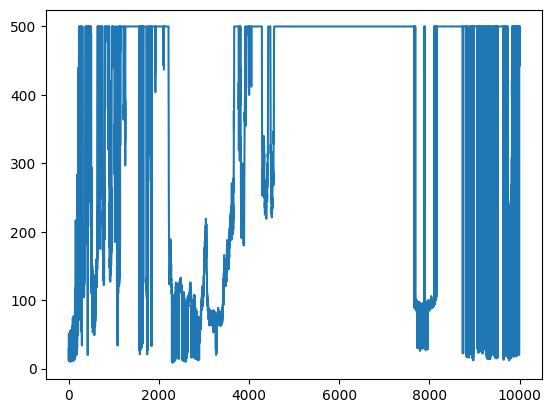

In [6]:
import matplotlib.pyplot as plt

x = np.arange(0,i_episode)
y = store_episode[0:i_episode].numpy()

fig, ax = plt.subplots()
ax.plot(x,y)

In [7]:
torch.save(store_episode[0:i_episode], "REINFORCE_baseline_result")